# Environment Setup

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Data

In [20]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

iris = load_iris()
X = iris.data
y = iris.target

In [21]:
# y to one-hot encoding
y = y.reshape(-1, 1) # parse to 2D to encoder
encoder = OneHotEncoder(sparse=False) # False return a numpy
y = encoder.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
len(y[0])

3

# Build NN
<img width="400" src="https://lh3.google.com/u/0/d/1LQm-3bMxBxhq0jSNEWyXgijbbSfLLbVr=w2992-h1654-iv2"></img>

In [24]:
import torch.nn.init as init
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1,  hidden_size2, output_size, weight_initializer):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)  # First hidden layer
    self.relu = nn.ReLU()  # ReLU activation function
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Output layer
    self.fc3 = nn.Linear(hidden_size2, output_size)  # Output layer

    self._initialize_weight(weight_initializer)

  @staticmethod
  def he_normal_init_weight(m):
      if isinstance(m, nn.Linear):
          fan_in = m.weight.size(1)
          std = math.sqrt(2.0 / fan_in)
          m.weight.data.normal_(0, std)
          if m.bias is not None:
              m.bias.data.zero_()

  @staticmethod
  def self_defined_init_weight(m):
      if isinstance(m, nn.Linear):
          fan_in = m.weight.size(1)
          fan_out = m.weight.size(0)
          std_dev = math.sqrt(2.0 / (fan_in * fan_out))
          m.weight.data.normal_(0, std_dev)
          if m.bias is not None:
              m.bias.data.zero_()

  def _initialize_weight(self, weight_initializer):
    if weight_initializer == "he":
        self.apply(NeuralNetwork.he_normal_init_weight)
    elif weight_initializer == "self":
        self.apply(NeuralNetwork.self_defined_init_weight)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out) # output of the last layer

    return F.softmax(out, dim=1) # pass to softmat to become probability

In [25]:
he_model = NeuralNetwork(X_train.shape[1], 128, 64, 3, "he")
self_model = NeuralNetwork(X_train.shape[1], 128, 64, 3, "self")

In [26]:
he_optimizer = optim.Adam(he_model.parameters(), lr=0.001)
self_optimizer = optim.Adam(self_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training
* metrics: convergence time

In [27]:
def calculate_accuracy(y_true, y_pred):
    # print(y_true, y_pred)
    predicted = torch.argmax(y_pred, dim=1) # get the most like class
    gt = torch.argmax(y_true, dim=1)

    correct = (predicted == gt).float().sum()

    return correct.item() / float(len(gt))

In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [29]:
train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size

In [30]:
# Create a DataLoader for your training data
train_dataset = TensorDataset(X_train, y_train)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [31]:
# Define epoch
num_epochs = 100

## He Normal

In [32]:
train_losses = []  # list to store loss values
val_losses = []
train_accs = []

train_preds = []
val_preds = []
val_accs = []

for epoch in range(num_epochs):

    # training phase
    he_model.train()
    train_loss = 0
    train_acc = 0.0

    for data in train_loader: # a batch
        inputs, labels = data
        he_optimizer.zero_grad()  # Zero the gradient buffers
        outputs = he_model(inputs)  # Get network outputs (forward propagation)
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss (backward propagation)
        he_optimizer.step()  # Update the weights

        train_loss += loss.item()  # accumulate loss per batch
        train_preds += outputs

        train_acc += calculate_accuracy(labels, outputs)

    train_loss /= len(train_loader)  # average loss for the epoch
    train_losses.append(train_loss)  # store average loss for the epoch

    train_acc = train_acc / len(train_loader)
    train_accs.append(train_acc)

    # validation phase
    he_model.eval()
    val_loss = 0
    val_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            outputs = he_model(data) # forward propagation
            loss = loss_fn(outputs, target)

            val_loss += loss.item()
            val_preds += outputs
            val_acc += calculate_accuracy(target, outputs)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valiation Loss: {val_loss}, Training Acc: {train_acc}, Validation Acc: {val_acc}')

Epoch 1/100, Train Loss: 0.9993942578633627, Valiation Loss: 0.876646101474762, Training Acc: 0.5208333333333334, Validation Acc: 0.7083333333333334
Epoch 2/100, Train Loss: 0.8948555986086527, Valiation Loss: 0.806009829044342, Training Acc: 0.6458333333333334, Validation Acc: 0.7083333333333334
Epoch 3/100, Train Loss: 0.8104765216509501, Valiation Loss: 0.7773541808128357, Training Acc: 0.71875, Validation Acc: 0.9166666666666666
Epoch 4/100, Train Loss: 0.7905555367469788, Valiation Loss: 0.8303513526916504, Training Acc: 0.78125, Validation Acc: 0.625
Epoch 5/100, Train Loss: 0.7558424671490988, Valiation Loss: 0.7415583729743958, Training Acc: 0.8333333333333334, Validation Acc: 0.9166666666666666
Epoch 6/100, Train Loss: 0.7526962757110596, Valiation Loss: 0.7481308579444885, Training Acc: 0.8333333333333334, Validation Acc: 0.75
Epoch 7/100, Train Loss: 0.7486083507537842, Valiation Loss: 0.7245979309082031, Training Acc: 0.7916666666666666, Validation Acc: 0.9583333333333334
E

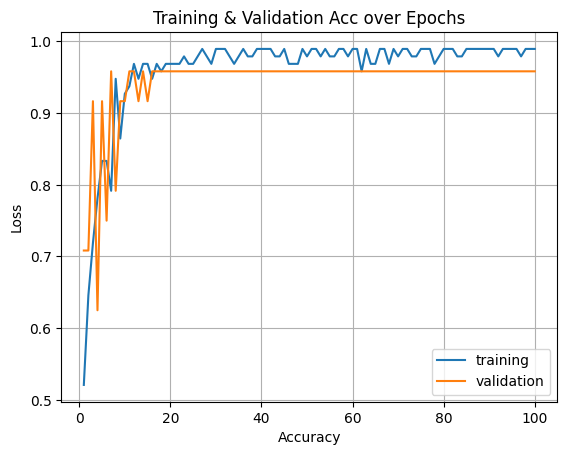

In [33]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label="training")
plt.plot(range(1, num_epochs+1), val_accs, label="validation")

plt.title('Training & Validation Acc over Epochs')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# We found out we can early stop at epoch 20

## Self Normal

In [34]:
train_losses = []  # list to store loss values
val_losses = []
train_accs = []

train_preds = []
val_preds = []
val_accs = []

for epoch in range(num_epochs):

    # training phase
    self_model.train()
    train_loss = 0
    train_acc = 0.0

    for data in train_loader: # a batch
        inputs, labels = data
        self_optimizer.zero_grad()  # Zero the gradient buffers
        outputs = self_model(inputs)  # Get network outputs (forward propagation)
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss (backward propagation)
        self_optimizer.step()  # Update the weights

        train_loss += loss.item()  # accumulate loss per batch
        train_preds += outputs

        train_acc += calculate_accuracy(labels, outputs)

    train_loss /= len(train_loader)  # average loss for the epoch
    train_losses.append(train_loss)  # store average loss for the epoch

    train_acc = train_acc / len(train_loader)
    train_accs.append(train_acc)

    # validation phase
    self_model.eval()
    val_loss = 0
    val_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            outputs = self_model(data) # forward propagation
            loss = loss_fn(outputs, target)

            val_loss += loss.item()
            val_preds += outputs
            val_acc += calculate_accuracy(target, outputs)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valiation Loss: {val_loss}, Training Acc: {train_acc}, Validation Acc: {val_acc}')

Epoch 1/100, Train Loss: 1.0985763867696126, Valiation Loss: 1.087192177772522, Training Acc: 0.2604166666666667, Validation Acc: 0.375
Epoch 2/100, Train Loss: 1.0890541076660156, Valiation Loss: 1.0804194211959839, Training Acc: 0.3125, Validation Acc: 0.375
Epoch 3/100, Train Loss: 1.0815555651982625, Valiation Loss: 1.0723110437393188, Training Acc: 0.3125, Validation Acc: 0.375
Epoch 4/100, Train Loss: 1.0732085704803467, Valiation Loss: 1.0624178647994995, Training Acc: 0.375, Validation Acc: 0.6666666666666666
Epoch 5/100, Train Loss: 1.0628772576649983, Valiation Loss: 1.0488382577896118, Training Acc: 0.59375, Validation Acc: 0.7083333333333334
Epoch 6/100, Train Loss: 1.0502649148305256, Valiation Loss: 1.0324294567108154, Training Acc: 0.6458333333333334, Validation Acc: 0.7083333333333334
Epoch 7/100, Train Loss: 1.0359707276026409, Valiation Loss: 1.0125771760940552, Training Acc: 0.6458333333333334, Validation Acc: 0.7083333333333334
Epoch 8/100, Train Loss: 1.01848415533

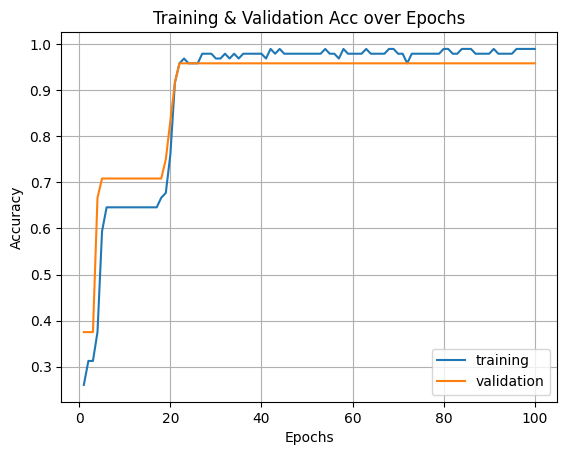

In [35]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label="training")
plt.plot(range(1, num_epochs+1), val_accs, label="validation")

plt.title('Training & Validation Acc over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# We found that it is worse than he_normal to converge.